# _(Diesmann, et, al., 1999)_ Synfire Chains

Implementation of the paper:

- Diesmann, Markus, Marc-Oliver Gewaltig, and Ad Aertsen. "Stable propagation of synchronous spiking in cortical neural networks." Nature 402.6761 (1999): 529-533.

In [1]:
import brainpy as bp
import numpy as np

bp.backend.set('numba')

In [2]:
duration = 100.  # ms

# Neuron model parameters
Vr = -70.  # mV
Vt = -55.  # mV
tau_m = 10.  # ms
tau_ref = 1.  # ms
tau_psp = 0.325  # ms
weight = 4.86  # mV
noise = 39.24  # mV

# Neuron groups
n_groups = 10
group_size = 100
spike_sigma = 1.

# Synapse parameter
delay = 5.0  # ms

In [3]:
# neuron model
# ------------


class Groups(bp.NeuGroup):
    target_backend = ['numpy', 'numba']

    def __init__(self, size, **kwargs):
        self.V = Vr + np.random.random(size) * (Vt - Vr)
        self.x = np.zeros(size)
        self.y = np.zeros(size)
        self.spike = np.zeros(size)
        self.not_ref = np.ones(size)
        self.t_last_spike = np.ones(size) * -1e7
        super(Groups, self).__init__(size, **kwargs)

    @staticmethod
    @bp.odeint
    def int_V(V, t, x):
        return (-(V - Vr) + x) / tau_m

    @staticmethod
    @bp.odeint
    def int_x(x, t, y):
        return (-x + y) / tau_psp

    @staticmethod
    @bp.sdeint(g=lambda y, t: noise)
    def int_y(y, t):
        df = -y / tau_psp + 25.27
        return df

    def update(self, _t, ):
        self.x = self.int_x(self.x, _t, self.y)
        self.y = self.int_y(self.y, _t)

        for i in range(self.num):
            self.spike[i] = 0.
            self.not_ref[i] = 0.
            if _t - self.t_last_spike[i] >= tau_ref:
                V = self.int_V(self.V[i], _t, self.x[i])
                if V > Vt:
                    self.spike[i] = 1.
                    self.t_last_spike[i] = _t
                    self.V[i] = Vr
                else:
                    self.V[i] = V
                    self.not_ref[i] = 1.

In [4]:
# synaptic  model
# ---------------

class SynBetweenGroups(bp.SynConn):
    target_backend = ['numpy', 'numba']

    def __init__(self, group, ext_group, **kwargs):
        self.mat1 = np.ones((ext_group.num, group_size))
        self.mat2 = np.ones((group_size, group_size))

        self.g = self.register_constant_delay('g', size=group.num, delay_time=delay)

        self.group = group
        self.ext = ext_group

        super(SynBetweenGroups, self).__init__(steps=[self.update], **kwargs)

    def update(self):
        # synapse model between external and group 1
        g = bp.backend.zeros(self.group.num)
        g[:group_size] = weight * np.dot(self.ext.spike, self.mat1)
        # feed-forward connection
        for i in range(1, n_groups):
            s1 = (i - 1) * group_size
            s2 = i * group_size
            s3 = (i + 1) * group_size
            g[s2: s3] = weight * np.dot(self.group.spike[s1: s2], self.mat2)
        # delay push
        self.g.push(g)
        # delay pull
        self.group.y += self.g.pull()

In [5]:
# Spike time group
# ----------------

class SpikeTimeInput(bp.NeuGroup):
    target_backend = ['numpy', 'numba']

    def __init__(self, size, times, indices, need_sort=1., **kwargs):
        if len(indices) != len(times):
            raise ValueError(f'The length of "indices" and "times" must be the same. '
                             f'However, we got {len(indices)} != {len(times)}.')

        # data about times and indices
        self.idx = 0
        self.times = np.ascontiguousarray(times, dtype=np.float_)
        self.indices = np.ascontiguousarray(indices, dtype=np.int_)
        self.num_times = len(times)
        if need_sort:
            sort_idx = np.argsort(times)
            self.indices = self.indices[sort_idx]
        self.spike = bp.backend.zeros(bp.size2len(size))

        super(SpikeTimeInput, self).__init__(size=size, **kwargs)

    def update(self, _t):
        self.spike[:] = 0.
        while self.idx < self.num_times and _t >= self.times[self.idx]:
            idx = self.indices[self.idx]
            self.spike[idx] = 1.
            self.idx += 1

In [6]:
# network running
# ---------------

def run_network(spike_num=48):
    times = np.random.randn(spike_num) * spike_sigma + 20
    ext_group = SpikeTimeInput(spike_num, times=times, indices=np.arange(spike_num))
    group = Groups(size=n_groups * group_size, monitors=['spike'])
    syn_conn = SynBetweenGroups(group, ext_group)

    net = bp.Network(group, ext_group, syn_conn)
    net.run(duration, report=True)

    bp.visualize.raster_plot(net.ts, group.mon.spike, xlim=(0, duration), show=True)

When external spike num is 51, there exists "synfire chain".

Compilation used 6.0236 s.
Start running ...
Run 10.0% used 0.010 s.
Run 20.0% used 0.018 s.
Run 30.0% used 0.030 s.
Run 40.0% used 0.037 s.
Run 50.0% used 0.049 s.
Run 60.0% used 0.060 s.
Run 70.0% used 0.069 s.
Run 80.0% used 0.081 s.
Run 90.0% used 0.091 s.
Run 100.0% used 0.098 s.
Simulation is done in 0.098 s.



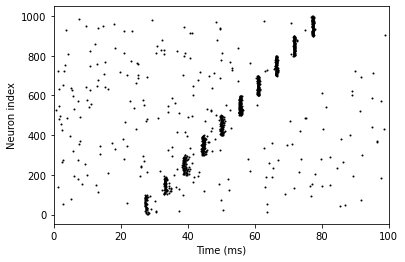

In [7]:
run_network(spike_num=51)

When external spike num is 44, the synchronous excitation disperses and eventually dies out.

Compilation used 2.5361 s.
Start running ...
Run 10.0% used 0.009 s.
Run 20.0% used 0.018 s.
Run 30.0% used 0.025 s.
Run 40.0% used 0.033 s.
Run 50.0% used 0.041 s.
Run 60.0% used 0.051 s.
Run 70.0% used 0.059 s.
Run 80.0% used 0.069 s.
Run 90.0% used 0.077 s.
Run 100.0% used 0.087 s.
Simulation is done in 0.088 s.



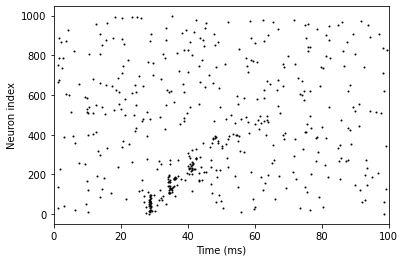

In [8]:
run_network(spike_num=44)